# Libs

In [ ]:
import os
import time
import glob
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Reshape, Activation, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Concatenate, Add, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, constant
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, normalize

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

import lightgbm as lgb

# Load Data

In [3]:
avi_train_seg = np.load('../Data/avi_train_seg.npy')
trj_train_seg = np.load('../Data/trj_train_seg.npy')
lane_functions = np.load('../Data/lane_functions.npy')

In [4]:
num_lanes = lane_functions.sum(axis=1)
lane_functions = pd.DataFrame(lane_functions,columns=['through','left','right',
                                                      'thr_left','thr_right','u_turn'])
lane_functions['linkIdx'] = np.arange(1,25)
lane_functions['num_lanes'] = num_lanes

# Data Preparation

## Sample Preparation

In [5]:
def get_sample(trj_train_seg):
    data = pd.DataFrame(columns=['linkIdx','datetime','volume'])
    for approach in range(24):
        table = pd.DataFrame(np.zeros((30 * 144,3)),columns=['linkIdx','datetime','volume'])
        table.iloc[:,0] = approach + 1
        for day in range(30):
            if day < 9:
                datetime = [pd.to_datetime('2018010' + str(day + 1)) + pd.Timedelta(i * 10,unit='m') for i in range(144)]
            else:
                datetime = [pd.to_datetime('201801' + str(day + 1)) + pd.Timedelta(i * 10,unit='m') for i in range(144)]
            table.iloc[144 * day:144 * (day + 1),2] = trj_train_seg[day,:,approach]
            table.iloc[144 * day:144 * (day + 1),1] = datetime
        data = pd.concat((data,table))
    data['linkIdx'] = data['linkIdx'].astype('int')
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['volume'] = data['volume'].astype('float')
    return data

In [188]:
X, Y = get_sample(trj_train_seg), get_sample(avi_train_seg)
print("[Basic Stats] num. of samples: {:d}".format(X.shape[0]))

[Basic Stats] num. of samples: 103680


## Feature Engineering

In [189]:
def holiday(x):
    if x.month == 1 and x.day == 1:
        return 1
    else:
        return 0

    
def peak(x):
    if 7 < x.hour < 9:
        return 1
    elif 11 < x.hour < 13:
        return 2
    elif 17 < x.hour < 19:
        return 3
    else:
        return 0

    
def itv_cnt(x, itv_length=600):
    return (x.hour * 3600 + x.minute * 60) // itv_length


def exponential_smoothing(alpha, s):
    s2 = np.zeros(s.shape)
    s2[0] = s[0]
    for i in range(1, len(s2)):
        s2[i] = alpha * s[i] + (1 - alpha) * s2[i - 1]
    return s2


def get_es_volume(trj_train_seg, alpha):
    trj_train_seg_es = trj_train_seg.copy()
    for day_idx in range(30):
        for seg_idx in range(24):
            seq = trj_train_seg[day_idx, :, seg_idx]
            seq_es = exponential_smoothing(alpha, seq)
            trj_train_seg_es[day_idx, :, seg_idx] = seq_es
    return get_sample(trj_train_seg_es)['volume']


def merge_volume_features(X, feature_cols, target_col, aggfuncs=['mean', 'median', 'std']):
    
    for feature in feature_cols:
        for fn in aggfuncs:
            df = X.pivot_table(index='linkIdx',
                               columns=feature,
                               values=target_col,
                               aggfunc=fn).reset_index()
            df.columns = ['linkIdx'] + list(df.columns[1:])
            df = df.melt(id_vars=['linkIdx'],
                         value_vars=list(df.columns[1:]),
                         var_name=feature,
                         value_name=feature + '_' + fn + '_' + target_col)
            df[feature] = pd.to_numeric(df[feature])
            X = pd.merge(X, df, on=['linkIdx',feature])
    return X

In [190]:
# =============================
# Feature Engineering
# =============================

# static attributes
X = pd.merge(X,lane_functions)
X['weekday'] = X['datetime'].map(lambda x:x.weekday())
X['interval'] = X['datetime'].map(lambda x:itv_cnt(x))
X['holiday'] = X['datetime'].map(lambda x:holiday(x))
X['peak'] = X['datetime'].map(lambda x:peak(x))
X['linkIdx'] = X['linkIdx'].astype(int)

# exponenrially smoothed volume
X['volume_es_p6'] = get_es_volume(trj_train_seg, alpha=0.6).values
X['volume_es_p5'] = get_es_volume(trj_train_seg, alpha=0.5).values

In [8]:
# cross volume features

feature_cols = ['through', 'left', 'right', 'thr_left',
                'thr_right', 'u_turn', 'num_lanes',
                'weekday', 'interval', 'holiday', 'peak']
X = merge_volume_features(X, feature_cols, target_col='volume')
X = merge_volume_features(X, feature_cols, target_col='volume_es_p6')
X = merge_volume_features(X, feature_cols, target_col='volume_es_p5')

# penetration rates
X['tmp'] = Y['volume'].values
interval_volume = X.pivot_table(index='interval',
                                values=['volume', 'tmp',
                                        'volume_es_p6', 'volume_es_p5'],
                                aggfunc='sum').reset_index()
interval_volume['penetration'] = interval_volume['volume'] / interval_volume['tmp']
interval_volume['penetration_p6'] = interval_volume['volume_es_p6'] / interval_volume['tmp']
interval_volume['penetration_p6'] = interval_volume['volume_es_p5'] / interval_volume['tmp']
interval_volume.drop(['tmp','volume','volume_es_p5','volume_es_p6'],axis=1,inplace=True)
X = pd.merge(X, interval_volume, on='interval')

# scaled volume
for up_idx, up_col in enumerate(['volume','volume_es_p6','volume_es_p5']):
    for down_idx, down_col in enumerate(['penetration','penetration_p6','penetration_p6']):
        X['scaled_volume_' + str(up_idx) + '_' + str(down_idx)] = X[up_col] / X[down_col]

# correlations & feature count
'''
X.corr().to_excel('../Data/feature_corr.xls')
'''
X.drop('tmp',axis=1,inplace=True)

In [192]:
# cat & num features
categorical_features = ['interval', 'weekday', 'holiday', 'peak']
numeric_features = list(set(X.drop(['datetime', 'linkIdx'], axis=1).columns) - set(categorical_features))
print("[Basic Stats] dim. of features: {:d}".format(X.shape[1]))

[Basic Stats] dim. of features: 16


## Evaluation Metric

In [9]:
def dataset_split(X, Y, split_mode):
    if split_mode is 'random':
        X_train, X_test, y_train, y_test = train_test_split(X.drop(['datetime','linkIdx'], axis=1),
                                                            Y['volume'],
                                                            test_size=0.2, random_state=2020)
    elif split_mode is 'fix_transfer':
        train_idx = X[X['linkIdx'].isin([1,2,3,4,5,6,7,8,24,23,22,21,20,19,18,17,15,16])].index
        test_idx = X[X['linkIdx'].isin([9,10,11,12,13,14])].index
        X_train, X_test = X.drop(['linkIdx', 'datetime'], axis=1).iloc[train_idx, :], X.drop(
            ['linkIdx', 'datetime'], axis=1).iloc[test_idx, :]
        y_train, y_test = Y['volume'].iloc[train_idx], Y['volume'].iloc[test_idx]
        
    elif split_mode is 'random_transfer':
        test_ls = np.unique(np.random.choice(np.arange(1,25),6))
        train_ls = list(set(np.arange(1,25)) - set(test_ls))
        train_idx = X[X['linkIdx'].isin(train_ls)].index
        test_idx = X[X['linkIdx'].isin(test_ls)].index
        X_train, X_test = X.drop(['linkIdx', 'datetime'], axis=1).iloc[train_idx, :], X.drop(
            ['linkIdx', 'datetime'], axis=1).iloc[test_idx, :]
        y_train, y_test = Y['volume'].iloc[train_idx], Y['volume'].iloc[test_idx]
        print("Train links: {:s} | Test links: {:s}".format(str(train_ls), str(test_ls)))
    else:
        print("split mode is wrong !")
        
    return X_train, X_test, y_train, y_test

In [10]:
def one_hot_encoding(X, categorical_features):
    one_hot_enc = OneHotEncoder()
    for feat in categorical_features:
        encoded_matrix = one_hot_enc.fit_transform(X[feat].values.reshape(-1,1)).toarray()
        num_class = encoded_matrix.shape[1]
        one_hot_features = pd.DataFrame()
        for class_ in range(num_class):
            one_hot_features[feat + '_' + str(class_)] = encoded_matrix[:,class_]
        X = pd.concat((X, one_hot_features),axis=1)
    return X

In [11]:
def mae(y_pred, y_test):
    return np.sum(np.abs(y_pred - y_test) * y_test) / np.sum(y_test)

def mape(y_pred, y_test):
    return np.sum(np.abs(y_pred - y_test)) / np.sum(y_test)

def mspe(y_pred, y_test):
    return np.sum(np.square(y_pred - y_test)) / np.sum(np.square(y_test))

In [206]:
X_nn = one_hot_encoding(X, categorical_features)
X_train, X_test, y_train, y_test = dataset_split(X, Y, 'random_transfer')

Train links: [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 24] | Test links: [ 5  8 13 14 23]


# Weight Samples

## KDE

In [ ]:
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
kde = kde.fit(X_test.values)
kde_weights = kde.score_samples(X_train.values)

## Logistic

In [ ]:
X_data = np.concatenate((X_train.values, X_test.values),axis=0)
y_data = np.concatenate((np.zeros((X_train.shape[0],1)), np.ones((X_test.shape[0],1))),axis=0)

In [ ]:
lr = LogisticRegression(penalty='l2',n_jobs=-1)
lr = lr.fit(X_data, y_data)
print("[Logistic] fit score: {:.3f}".format(lr.score(X_data, y_data)))
logit_weight = lr.predict_proba(X_train.values)[:,1]

## LGB

In [ ]:
X_data = pd.concat((X_train, X_test),axis=0)
y_data = np.concatenate((np.zeros((X_train.shape[0],1)), np.ones((X_test.shape[0],1))),axis=0)

In [ ]:
params = {
    'objective':'binary',
    'boosting':'gbdt',
    'num_rounds':1000,
    'learning_rate':0.01,
    'max_depth':5,
    'num_leaves':20,
    'bagging_fraction':0.5,
    'bagging_freq':100,
    'verbose':2
}

train_data = lgb.Dataset(X_data, y_data.reshape(-1),categorical_feature=['weekday','interval',
                                                                         'holiday','peak'])
gbm = lgb.train(params, train_data)

In [ ]:
lgb.plot_importance(gbm, max_num_features=20,grid=False,height=0.5)

In [ ]:
gbm_weights = gbm.predict(X_data)[:X_train.shape[0]]

## MLP

In [ ]:
def build_mlp_clf(input_shape):
    x_in = Input(shape=(input_shape))

    def dense_block(h, units):
        h = Dense(units=units, use_bias=True,
                  activation=None,
                  kernel_initializer=he_normal(),
                  bias_initializer=constant(0.0))(h)
        h = BatchNormalization()(h)
        h = LeakyReLU(0.2)(h)
        h = Dropout(rate=0.5)(h)
        return h

    h = dense_block(x_in, units=32)
    h = dense_block(h, units=16)
    h = Dense(units=1, use_bias=False,
              activation='sigmoid',
              kernel_initializer='normal',
              bias_initializer=constant(0.0))(h)

    mlp_clf = Model(inputs=x_in, outputs=h)
    mlp_clf.compile(loss='binary_crossentropy', optimizer=Adam(3e-4), metrics=['accuracy'])

    return mlp_clf

In [ ]:
mlp_clf = build_mlp_clf(input_shape=X_data.shape[1])
hist = mlp_clf.fit(X_data, y_data, batch_size=256, epochs=10, shuffle=True)

In [ ]:
mlp_weights = mlp_clf.predict(X_train.values)

# Train Regressor

In [167]:
trunc_kde_weights = -1 / kde_weights

In [203]:
train_data = lgb.Dataset(X_train, y_train, categorical_feature=['weekday','interval',
                                                                'holiday','peak'])
train_data.set_weight(gbm_weights)
test_data = lgb.Dataset(X_test, y_test, reference=train_data)

params = {
    'objective':'regression',
    'boosting':'gbdt',
    'metric':'mae',
    'num_rounds':2000,
    'learning_rate':0.01,
    'max_depth':8,
    'num_leaves':100,
    'feature_fraction':0.6,
    'bagging_fraction':0.6,
    'extra_trees':True,
    'bagging_freq':500,
    'verbose':2
}

gbm = lgb.train(params, train_data,valid_sets=[test_data])

[1]	valid_0's l1: 68.5453
[2]	valid_0's l1: 68.0307
[3]	valid_0's l1: 67.5472
[4]	valid_0's l1: 67.0558
[5]	valid_0's l1: 66.5826
[6]	valid_0's l1: 66.1134
[7]	valid_0's l1: 65.653
[8]	valid_0's l1: 65.1782
[9]	valid_0's l1: 64.7181
[10]	valid_0's l1: 64.2642
[11]	valid_0's l1: 63.8722
[12]	valid_0's l1: 63.4226
[13]	valid_0's l1: 62.9981
[14]	valid_0's l1: 62.5507
[15]	valid_0's l1: 62.1303
[16]	valid_0's l1: 61.8382
[17]	valid_0's l1: 61.4292
[18]	valid_0's l1: 61.0274
[19]	valid_0's l1: 60.6263
[20]	valid_0's l1: 60.2297
[21]	valid_0's l1: 59.9521
[22]	valid_0's l1: 59.6828
[23]	valid_0's l1: 59.2787
[24]	valid_0's l1: 58.8992
[25]	valid_0's l1: 58.5647
[26]	valid_0's l1: 58.5255
[27]	valid_0's l1: 58.2
[28]	valid_0's l1: 57.8095
[29]	valid_0's l1: 57.4456
[30]	valid_0's l1: 57.0886
[31]	valid_0's l1: 56.7569
[32]	valid_0's l1: 56.5318
[33]	valid_0's l1: 56.1733
[34]	valid_0's l1: 55.833
[35]	valid_0's l1: 55.4945
[36]	valid_0's l1: 55.1611
[37]	valid_0's l1: 54.9502
[38]	valid_0's 

In [204]:
y_pred = gbm.predict(X_train)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_train),
    100 * mape(y_pred,y_train), 100 * mspe(y_pred, y_train)))

y_pred = gbm.predict(X_test)

print("[LightGBM] mae: {:.2f} | mape: {:.2f}% | mspe: {:.2f}%".format(
    mae(y_pred, y_test),
    100 * mape(y_pred,y_test), 100 * mspe(y_pred, y_test)))

[LightGBM] mae: 15.96 | mape: 19.14% | mspe: 5.64%
[LightGBM] mae: 21.59 | mape: 19.42% | mspe: 5.38%


(0, 420)

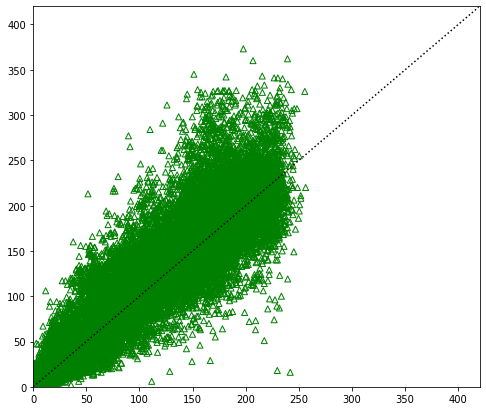

In [205]:
plt.figure(figsize=(8,7))
plt.scatter(y_pred,y_test,marker='^',c='',edgecolors='g')
plt.plot(np.arange(420),np.arange(420),'k:')
plt.xlim([0,420])
plt.ylim([0,420])